In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score as acc
import numpy as np
from lime import explanation
from lime import lime_base
import math

In [2]:
from lime_timeseries import LimeTimeSeriesExplainer

## Load Coffee Dataset

In [3]:
coffee_train = pd.read_csv('data/coffee_train.csv', sep=',', header=None).astype(float)
coffee_train_y = coffee_train.loc[:, 0]
coffee_train_x = coffee_train.loc[:, 1:]
coffee_test = pd.read_csv('data/coffee_test.csv', sep=',', header=None).astype(float)
coffee_test_y = coffee_test.loc[:, 0]
coffee_test_x = coffee_test.loc[:, 1:]

## Load ECG Dataset

In [4]:
ecg_train = pd.read_csv('data/ecg_test.csv', sep=',', header=None).astype(float)
ecg_train.replace([np.inf, -np.inf], np.nan).dropna()
ecg_train = ecg_train.loc[:186, :]
ecg_train_y = ecg_train.loc[:, 0]
ecg_train_x = ecg_train.loc[:, 1:]
ecg_test = pd.read_csv('data/ecg_train.csv', sep=',', header=None).astype(float)
ecg_test.replace([np.inf, -np.inf], np.nan).dropna()
ecg_test_y = ecg_test.loc[:, 0]
ecg_test_x = ecg_test.loc[:, 1:]

## Datasets

Let's plot the two time series datasets using different colors for each class.

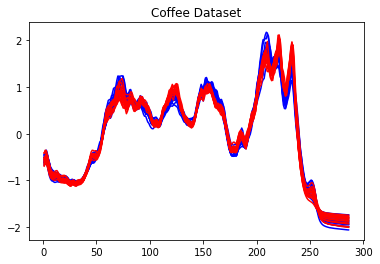

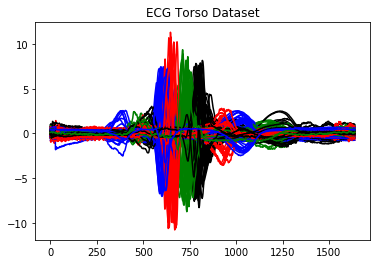

In [5]:
for idx in range(0, len(coffee_train)):
    if coffee_train_y[idx] == 0:
        plt.plot(coffee_train_x.loc[idx, :], 'b')
    else:
        plt.plot(coffee_train_x.loc[idx, :], 'r')
plt.title('Coffee Dataset')
plt.show()

for idx in range(0, len(ecg_train)):
    if ecg_train_y[idx] == 4:
        plt.plot(ecg_train_x.loc[idx, :], 'b')
    elif ecg_train_y[idx] == 1:
        plt.plot(ecg_train_x.loc[idx, :], 'r')
    elif ecg_train_y[idx] == 2:
        plt.plot(ecg_train_x.loc[idx, :], 'g')
    elif ecg_train_y[idx] == 3:
        plt.plot(ecg_train_x.loc[idx, :], 'black')
plt.title('ECG Torso Dataset')
plt.show()

### Compute Accuracy

We train a kNN classifier on that data and print the accuracy. We want to explain this classifier using LIME.

In [6]:
knn = KNN()
knn.fit(coffee_train_x, coffee_train_y)
knn2 = KNN()
knn2.fit(ecg_train_x, ecg_train_y)
print('Accuracy KNN for coffee dataset: %f' % (acc(coffee_test_y, knn.predict(coffee_test_x))))
print('Accuracy KNN for earthquake dataset: %f' % (acc(ecg_test_y, knn2.predict(ecg_test_x))))

Accuracy KNN for coffee dataset: 0.964286
Accuracy KNN for earthquake dataset: 0.900000


## Explaining Coffee Dataset

In [7]:
idx = 5 # explained instance
num_features = 10 # how many feature contained in explanation
num_slices = 24 # split time series
series = coffee_test_x.iloc[idx, :]

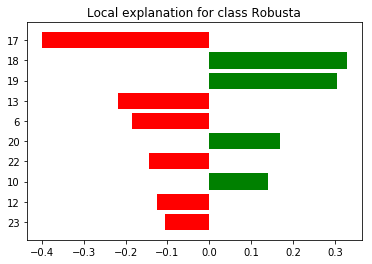

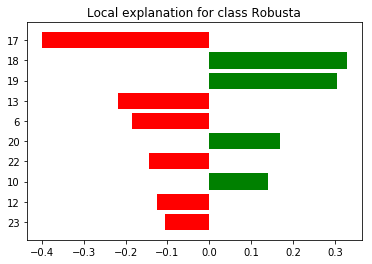

In [8]:
explainer = LimeTimeSeriesExplainer(class_names=['Arabica', 'Robusta'])
exp = explainer.explain_instance(series, knn.predict_proba, num_features=num_features, num_samples=5000, num_slices=num_slices, 
                                 replacement_method='total_mean')
exp.as_pyplot_figure()

Let's plot the relevant slices in our time series. Highlighted depending on their impact on the classification result.

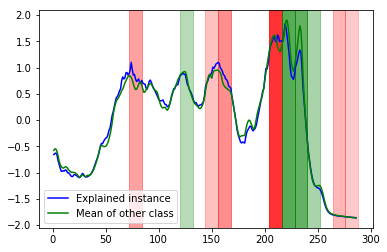

In [9]:
values_per_slice = math.ceil(len(series) / num_slices)
plt.plot(series, color='b', label='Explained instance')
plt.plot(coffee_test_x.iloc[15:,:].mean(), color='green', label='Mean of other class')
plt.legend(loc='lower left')

for i in range(num_features):
    feature, weight = exp.as_list()[i]
    start = feature * values_per_slice
    end = start + values_per_slice
    color = 'red' if weight < 0 else 'green' 
    plt.axvspan(start , end, color=color, alpha=abs(weight*2))
plt.show()

## Explaining ECG Dataset

In [20]:
idx_ecg = 11 # explained instance
num_features_ecg = 5 # how many feature contained in explanation
num_slices_ecg = 17 # split time series
series_ecg = ecg_test_x.iloc[idx_ecg, :]

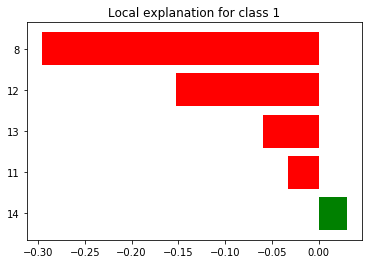

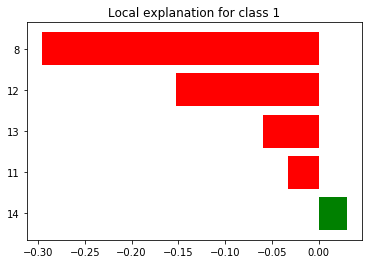

In [21]:
explainer2 = LimeTimeSeriesExplainer()
exp2 = explainer2.explain_instance(series_ecg, knn2.predict_proba, num_features=num_features_ecg, num_samples=500, num_slices=num_slices_ecg, 
                                 replacement_method='noise')
exp2.as_pyplot_figure()

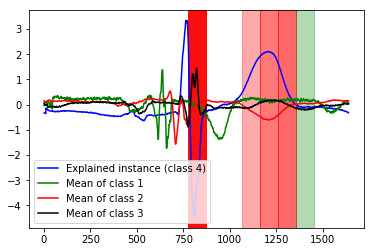

In [22]:
values_per_slice_ecg = math.ceil(len(series_ecg) / num_slices_ecg)
plt.plot(series_ecg, 'b', label='Explained instance (class 4)')
plt.plot(ecg_test_x.iloc[ecg_test_y[ecg_test_y == 1].index, :].mean(), color='green',
        label='Mean of class 1')
plt.plot(ecg_test_x.iloc[ecg_test_y[ecg_test_y == 2].index, :].mean(), color='red',
        label='Mean of class 2')
plt.plot(ecg_test_x.iloc[ecg_test_y[ecg_test_y == 3].index, :].mean(), color='black',
        label='Mean of class 3')
for i in range(num_features_ecg):
    feature, weight = exp2.as_list()[i]
    start = feature * values_per_slice_ecg
    end = start + values_per_slice_ecg
    color = 'red' if weight < 0 else 'green' 
    plt.axvspan(start , end, color=color, alpha=abs(weight*10))
plt.legend(loc='lower left')
plt.show()